In [1]:
import numpy as np
import matplotlib.pyplot as plt
from run import agents, run_agent, AgentStats
from numpy.typing import NDArray
from typing import NamedTuple, Sequence, Tuple
from deepsea import MultiRewardsDeepSea
import multiprocessing as mp
from scipy.stats import t as tstudent
import torch
from torch.multiprocessing import Pool, Process, set_start_method
try:
     set_start_method('spawn')
except RuntimeError:
    pass
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

class Results(NamedTuple):
    training_rewards: NDArray[np.float64]
    greedy_rewards: Sequence[Tuple[int, NDArray[np.float64]]]
    regret: NDArray[np.float64]
    agent_stats: AgentStats
    
    
def CE(x, c=0.95):
    N = x.shape[0]
    alpha = c + (1-c)/2
    c = tstudent.ppf(alpha, N)
    s = np.std(x, axis=0, ddof=1)
    return x.mean(0), c * s/ np.sqrt(N)
data = {}

/home/alessior/anaconda3/envs/exploration-maze/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
N_EPISODES = 1000
FREQ_EVAL_GREEDY = 100
NUM_EVAL_GREEDY = 20
NUM_PROC = 4
NUM_RUNS = 16
SIZE = 10
MAX_REWARD = 1
SLIPPING_PROBABILITY = 0.05

# agent_name: str, seed: int, multi_rewards: bool, size: int, max_reward: float, slipping_probability: float,
#                 num_episodes: int, freq_val_greedy: int, num_eval_greedy:int):

with Pool(NUM_PROC) as pool:
    for multi_rewards in [True]:
        key_dict = f'multi_rewards_enabled_{multi_rewards}'
        if key_dict not in data:
            data[key_dict] = {}
        for agent_name in ['explorative_generative_off_policy', 'boot_dqn_torch', 'ids']:
            print(f'Running agent {agent_name} - multi_rewards {multi_rewards}')
            training_rewards, greedy_rewards, regret, stats = zip(*pool.starmap(
                run_agent, [(agent_name, idx, multi_rewards, SIZE, MAX_REWARD, SLIPPING_PROBABILITY, N_EPISODES, FREQ_EVAL_GREEDY, NUM_EVAL_GREEDY) for idx in range(NUM_RUNS)]))
            data[key_dict][agent_name] = Results(training_rewards, greedy_rewards, regret, stats)
 

Running agent explorative_generative_off_policy - multi_rewards True


Ep. 672 - Regret: 81.289 - Last 10 ep. avg ret. 0.893 - Last greedy avg. ret. 0.892 (std 0.3):  67%|██████▋   | 673/1000 [02:27<01:10,  4.66it/s]/home/alessior/rl-exploration-maze/DeepSea/agents/explorative_generative_off_policy.py:295: RuntimeWarning: invalid value encountered in divide
  p = (H/H.sum(-1, keepdims=True))
Ep. 665 - Regret: 17.23 - Last 10 ep. avg ret. 0.896 - Last greedy avg. ret. 0.847 (std 0.357):  67%|██████▋   | 666/1000 [02:27<01:13,  4.52it/s]
Ep. 999 - Regret: 270.892 - Last 10 ep. avg ret. 0.891 - Last greedy avg. ret. 0.892 (std 0.299): 100%|██████████| 1000/1000 [03:34<00:00,  4.66it/s]
Ep. 999 - Regret: 114.578 - Last 10 ep. avg ret. 0.99 - Last greedy avg. ret. 0.741 (std 0.432): 100%|██████████| 1000/1000 [03:36<00:00,  4.63it/s]
Ep. 999 - Regret: 104.701 - Last 10 ep. avg ret. 0.994 - Last greedy avg. ret. 0.796 (std 0.4): 100%|██████████| 1000/1000 [03:36<00:00,  4.61it/s] 
Ep. 999 - Regret: 103.536 - Last 10 ep. avg ret. 0.794 - Last greedy avg. ret. 0.

ValueError: probabilities contain NaN

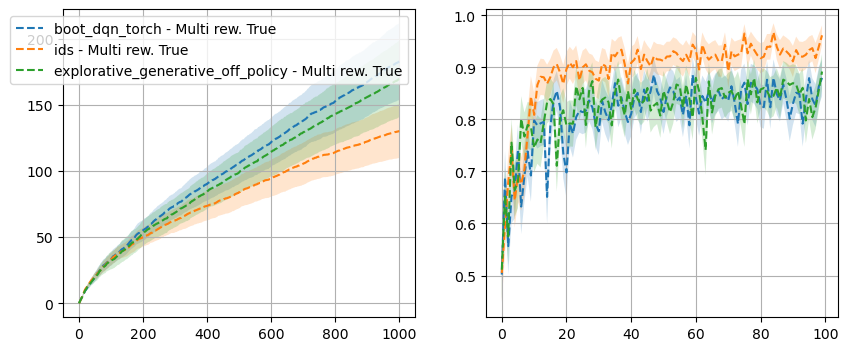

In [ ]:
styles = {
    True: '--',
    False: '-'
}
fig, ax = plt.subplots(1,2, figsize=(10,4))

for multi_rewards in [True]:
    for agent_name in ['boot_dqn_torch', 'ids','explorative_generative_off_policy']:
        agent_data = data[f'multi_rewards_enabled_{multi_rewards}'][agent_name]
        mu, ce = CE(np.array(agent_data.regret))

        t = np.arange(N_EPISODES + 1)
        ax[0].plot(t, mu, label=f'{agent_name} - Multi rew. {multi_rewards}', linestyle=styles[multi_rewards])
        ax[0].fill_between(t, np.clip(mu-ce,0,np.infty), mu+ce, alpha=0.2)
        
        greedy_data = np.array([list(zip(*agent_data.greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

        mu, ce = CE(greedy_data.swapaxes(1,2).reshape(-1, greedy_data.shape[1]))
        x = range(len(mu))
        ax[1].plot(x, mu, linestyle=styles[multi_rewards])
        ax[1].fill_between(x, np.clip(mu-ce,0, np.infty), mu+ce, alpha=0.2)

ax[0].grid()
ax[1].grid()
ax[0].legend()

In [ ]:
greedy_data = np.array([list(zip(*data['multi_rewards_enabled_False']['boot_dqn_torch'].greedy_rewards[x]))[1] for x in range(NUM_RUNS)])

mu_groups, std_groups = greedy_data.mean(-1), greedy_data.std(-1, ddof=1)
RSS, ESS = std_groups.mean(0), mu_groups.std(0, ddof=1)
mu, std = mu_groups.mean(0), RSS+ESS


alpha = .95 + (1-.95)/2
c = tstudent.ppf(alpha, 5)
se = c * std/ np.sqrt(5)

x = range(len(mu))
plt.plot(x, mu)
plt.fill_between(x, np.clip(mu-se,0, np.infty), mu+se, alpha=0.2)

#plt.plot(x, ESS)

KeyError: 'multi_rewards_enabled_False'